# Вычислительная математика
## Преобразование Фурье

Ярослав Холодов

## Анализ сезонности во временных рядах
Во временных рядах нередко присутствует периодическая (сезонная) составляющая. 
Например, продажи в магазинах растут в субботу и воскресение, а также в канун Нового Года. Рост пассажиропотока увеличивается к летним месяцам. 
Таких сезонных составляющих может быть много, и выявить их порой непросто. Посмотрим детально, как выделить сезонность во временных рядах.

Для начала смоделируем временной ряд. Предположим, что у нас есть данные о продажах за 3 года с периодом взятия выборки в 1 день.

Пусть в графике продаж присутствуют следующие сезонные факторы:

* Годовой — на Новый Год продажи растут.
* Квартальный — ежеквартально люди получают премии, у них появляется больше денег, и они склонны больше тратить.
* Еженедельный — на субботу и воскресение продажи вырастают.
* Есть некоторый искажающий фактор (шум), влияющий на объем продаж.

Временной ряд создадим с помощью Pandas.DataFrame.

In [ ]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt #Отрисовка графиков
# if using a jupyter notebook
%matplotlib inline 
years = 3               #Number of the years
months = 12             #Number of the months per year
quarters = 4            #Number of quarters per a year
weeks = 4               #Number of weeks per month
GBPUSD = pd.DataFrame(columns=['date_time', 'value'])
start_date = date(2019, 1, 1)
end_date = start_date.replace(year=start_date.year + years)
time = pd.date_range(start = start_date, end = end_date, freq = 'D')
print(start_date, end_date, time.shape[0])
GBPUSD['date_time'] = time
GBPUSD.index = time

2019-01-01 2022-01-01 1097


Берем исходную дату 01.01.2019 в качестве начала временного ряда и количество years = 3, задав частоту дискретизации freq = ‘D’ = 1 день.

В случае с временным рядом, описывающим продажи за определенный промежуток времени, 
аналогом общепринятого в цифровой обработке сигналов промежутка в 1 сек., выступает весь интервал взятия выборок,
т.е. SR = количеству дней за 3 года.

In [ ]:
SR = time.size                                              #Total number of samples in the time series
f_year = years                                              #Frequency for the year period
f_quarter = years*quarters                                  #Frequency for the quarter period
f_week = years*months*weeks                                 #Frequency for the week period
fi = np.pi/2                                                #The phase shift
t = np.linspace(0, SR, SR)                                  #Generate time axis
y_year = np.sin(2*np.pi*f_year*t + fi) + 1                  #Create time series for years
y_quarter = 0.7*np.sin(2*np.pi*f_quarter*t + fi) + 1        #Create time series for quarters
y_week = 0.5*np.sin(2*np.pi*f_week*t + fi) + 3              #Create time series for weeks
noise = np.random.uniform(-1.,1., SR)                       #Create noise 
y_mix = y_year + y_quarter + y_week + noise + 1.5           #Combine all time series

Соответственно определяем, что:

f_year = years = 3 — частота повторения по годам. 
Данные у нас взяты за 3 года, соответственно, частота = 3.

f_quarter = years*quarters = 12 — квартальная частота повторения.

f_week = years*months*weeks = 144 — недельные повторения.

Чтобы визуально гармонические составляющие для годовых, квартальных и недельных сезонных составляющих хорошо визуализировались на графике, 
добавляем постоянную составляющую для сдвига по оси y. В этом случае сезонные составляющие получаются более физичными, поскольку отрицательные продажи — это убыток. 

Фаза fi = pi/2 смещает максимальное значение на начало года, делая более физичным, поскольку максимум продаж приходится на дату в районе 1 января каждого года. 
Можно вместо sin взять cos, чтобы не добавлять фазовый сдвиг.

Поскольку на данный момент в качестве time берется ряд дат, для формирования временной последовательности, 
которую можно будет подать в качестве аргумента для sin, нужно сформировать числовую последовательность. 
Количество отсчетов в последовательности должно быть равно количеству дат в исходном ряде. 
В данном случае максимальное значение в ряде равно SR, и общее количество отсчетов (третий аргумент функции) взято также SR.

Отобразим созданные временные ряды на графике.

Частота квартальная: 12
Частота недельная: 144


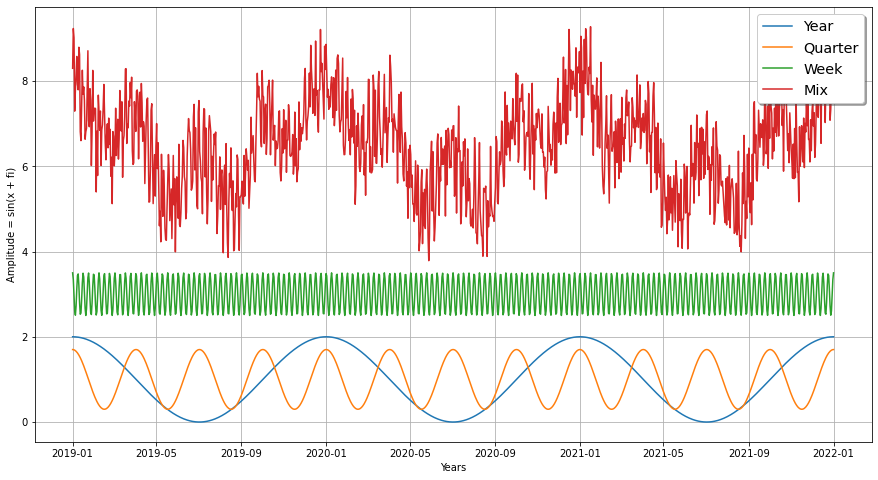

In [ ]:
t = np.linspace(0, SR, SR)                 #Generate time axis
print("Частота квартальная:", f_quarter)
print("Частота недельная:", f_week)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.ylabel('Amplitude = sin(x + fi)')
plt.xlabel('Years')
plt.grid(True, which='both')
plt.plot(time, y_year, label='Year')
plt.plot(time, y_quarter, label='Quarter')
plt.plot(time, y_week, label='Week')
plt.plot(time, y_mix, label='Mix')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
#legend.get_frame().set_facecolor('C0')
plt.show()

## Дискретное преобразование Фурье

Любой временной ряд может быть представлен в виде суммы гармонических функций с различными амплитудами, частотами и фазами. 

Подобный ряд гармонических функций называется рядом Фурье. 

Трансформация сигнала во временной области в частотную называется преобразованием Фурье.

В нашем случае ряд Фурье представлен в виде суммы трех гармонических функций.
Это модельный вариант, однако он дает возможность проверить наличие во временном ряде явно выраженных сезонны факторов.
Воспользуемся встроенными функциями Python numpy для дискретного преобразования Фурье. 
Поскольку сигнал действительный, то для ускорения использовалась функция rfft.

In [ ]:
#SR = t.size  #частота дискретизации, отсчётов в секунду
N = SR # длина входного массива.
# Вычисляем преобразование Фурье. Сигнал действительный, поэтому надо использовать rfft, это быстрее, чем fft
spectrum = np.fft.rfft(y_week)
orig = spectrum.copy()
freq = np.fft.rfftfreq(N, 1./SR) #Frequency axis
spectrum = 1/N * np.abs(spectrum)
spectrum[1:] = spectrum[1:]*2 # Удваиваем значение амплитуды всех гармоник за исключением 0-й 

Амплитуда 0-й гармоники (постоянная составляющая — сдвиг по оси y) не требует преобразования по амплитуде. 
Амплитуду других гармоник необходимо умножить на 2, чтобы получить корректное значение амплитуды исходного гармонического сигнала.
Частота временного ряда = 144, говорит об 144 изменениях за период в 3 года.

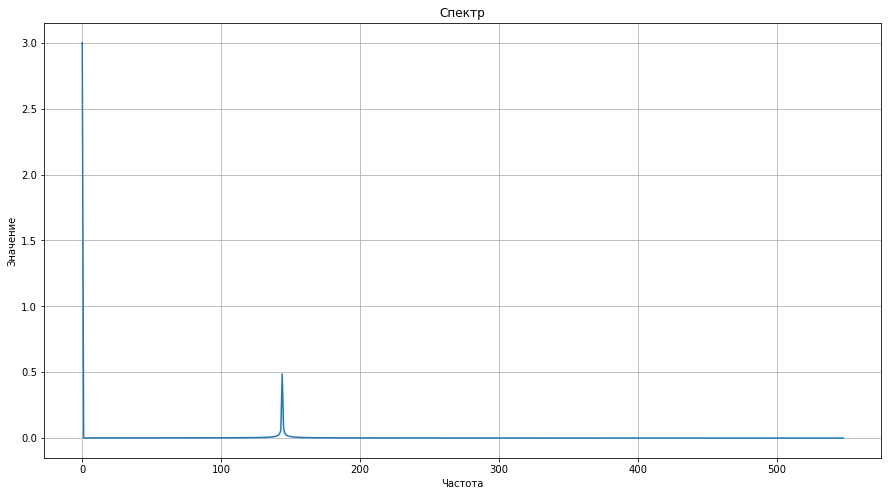

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.plot(freq, spectrum)
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в частоту
# интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы скорректировать амплитуду. Постоянные составляющие должны совпадать в смоделированном гармоническом сигнале и в спектре
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

Заметим, что полученная постоянная составляющая равна 3, что соответствует исходной величине амплитуды, заданной при создании функции. 
Постоянная составляющая (0-я гармоника) нередко значительная, поэтому отобразим на другом графике полученное преобразование, исключив гармонику с 0-й частотой.

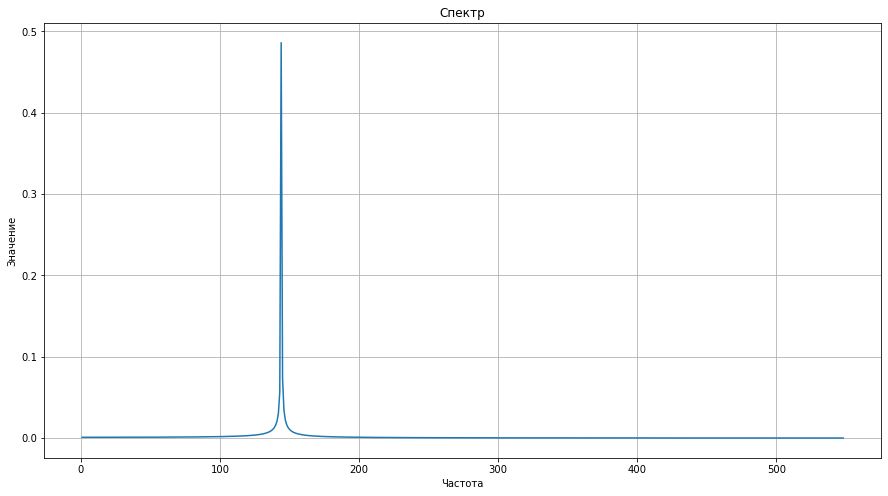

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.plot(freq[1:], spectrum[1:])
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

Как видно по графику, на частоте, равной 144, выявлена гармоника с амплитудой 0.5, что соответствует заданной при моделировании временного ряда.

Сделаем теперь преобразование Фурье для смешанного временного ряда, заменив аргумент на y_mix.

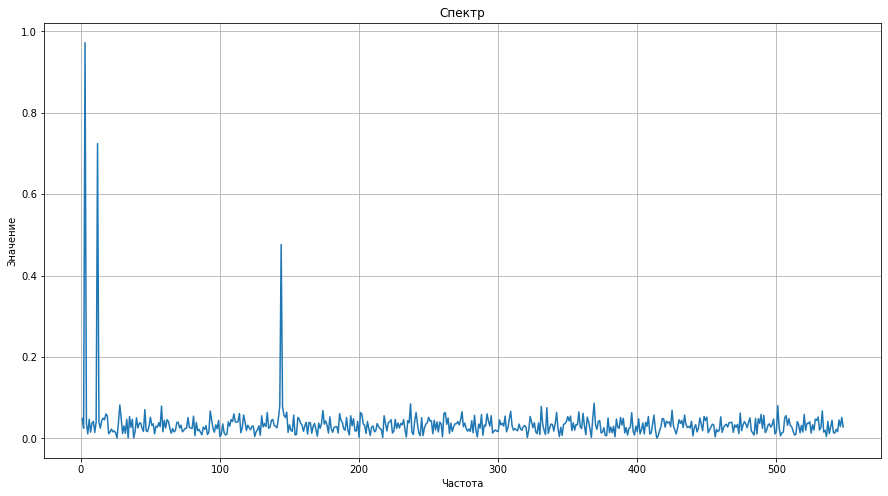

In [ ]:
spectrum = np.fft.rfft(y_mix)
orig = spectrum.copy()
spectrum = 1/N * np.abs(spectrum)
spectrum[1:] = spectrum[1:]*2
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.plot(freq[1:], spectrum[1:])
plt.xlabel(u'Частота')
plt.ylabel(u'Значение')
plt.title(u'Спектр')
plt.grid(True)
plt.show()

На графике видно, что амплитуда самой низкой годовой (с частотой = 3) = 1, квартальной (с частотой = 12) = 0.7 и недельной (с частотой = 144) = 0.5 на фоне гармоник «белого шума» с низкой амплитудой.

В частотной области легко произвести очистку исходного временного ряда, отбросив значения ниже определенного уровня, соответствующие шуму, и оставив только нужные гармоники. 
Затем можно произвести обратное преобразование Фурье и получить исходный временной ряд, очищенный от шума.

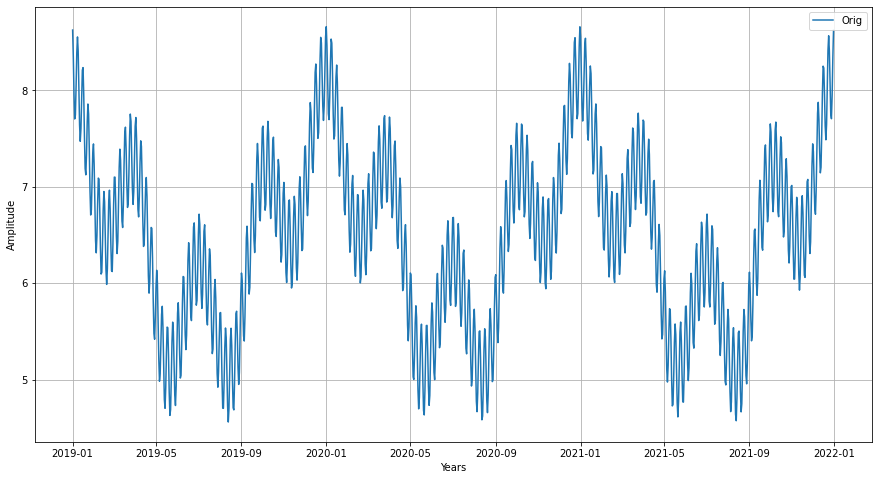

In [ ]:
orig_wo_noise = orig.copy()
orig_wo_noise[orig_wo_noise < 70] = 0
s = np.fft.irfft(orig_wo_noise)
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.ylabel('Amplitude')
plt.xlabel('Years')
plt.grid(True, which='both')
plt.plot(time[:-1], s, label='Orig')
legend = ax.legend(loc='upper right')
plt.show()

При анализе наблюдений важно понимать, есть ли во временном ряде явно выраженные сезонные факторы. 
Нейронные сети позволяют выявить подобные закономерности неявно, работая как «черный ящик», т.е. предсказание может быть весьма точным, но почему оно такое, понять нельзя. 
Нередко матобработка временного ряда перед подачей на нейронную сеть позволяет существенно улучшить качество прогноза нейронкой.
Поэтому предварительный анализ временного ряда различными преобразованиями, в т.ч. Фурье весьма полезны.

# Задание 1. Фурье-преобразование картинки. 

Сделайте преобразование Фурье от картинки в файле im1.jpg, используя файл rian.py.   Сохраните двумерный фурье-образ в файле out.jpg (параметры цвета r, g, b округлять до целых чисел).  Удалите из фурье-образа верхнюю половину пространственных частот по каждой координате. Сделайте обратное преобразование и сохраните в файле  out2.jpg 

Указание. 

Методом двумерного преобразования Фурье (two-dimensional Fourier transform - 2-DFT) является преобразование Фурье, произведенное над двумерным массивом данных. Рассмотрим двумерный массив данных.  Эти данные имеют два измерения: x и y. Преобразование Фурье над данными производится сначала в одном, а затем в другом направлениях. 

Первая часть преобразования Фурье проводится в x измерении. Вторая часть преобразования Фурье производится в y измерении.


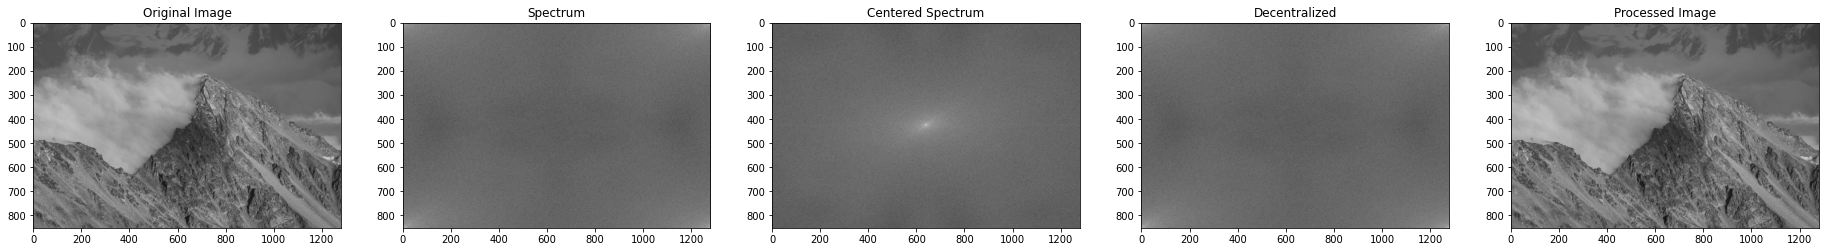

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

img_c1 = cv2.imread("smokin_peak.jpeg", 0)
img_c2 = np.fft.fft2(img_c1)
img_c3 = np.fft.fftshift(img_c2)
img_c4 = np.fft.ifftshift(img_c3)
img_c5 = np.fft.ifft2(img_c4)

plt.subplot(151), plt.imshow(img_c1, "gray"), plt.title("Original Image")
plt.subplot(152), plt.imshow(np.log(1+np.abs(img_c2)), "gray"), plt.title("Spectrum")
plt.subplot(153), plt.imshow(np.log(1+np.abs(img_c3)), "gray"), plt.title("Centered Spectrum")
plt.subplot(154), plt.imshow(np.log(1+np.abs(img_c4)), "gray"), plt.title("Decentralized")
plt.subplot(155), plt.imshow(np.abs(img_c5), "gray"), plt.title("Processed Image")

plt.show()

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

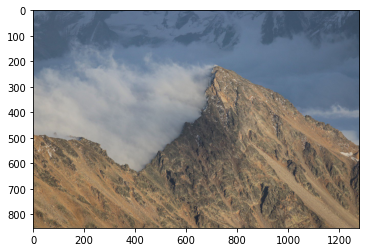

In [53]:
from PIL import Image
img = Image.open("smokin_peak.jpeg")
# img = Image.open("ya.jpeg")
# img = Image.open("car.jpeg")
orig_img = np.asarray(img)
plt.imshow(orig_img);
plt.show();

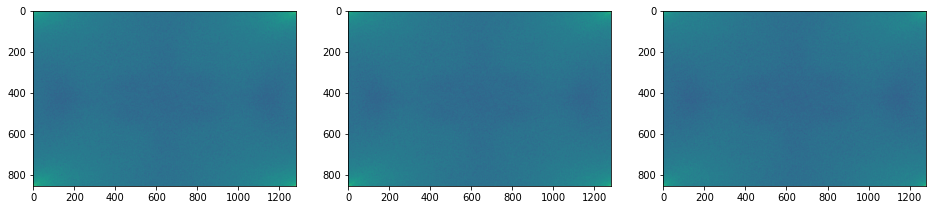

In [54]:
channels = img.split()
fourier_channels = []
plt.figure(figsize=(16, 9))

for i in range(0, 3):
    fourier_channels.append(np.fft.fft2(channels[i], axes = (0,1)))
    plt.subplot(1, 3, i+1)
    plt.imshow(np.log(np.abs(fourier_channels[-1])))

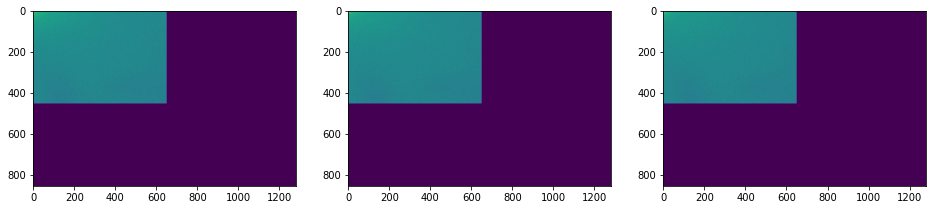

In [55]:
plt.figure(figsize=(16, 9))
transformed_channels = []
for i in range(0, 3):
    fourier_channels[i][:, 650:] = 1
    fourier_channels[i][450:, :650] = 1
    transformed_channels.append(np.abs(np.fft.ifft2(fourier_channels[i])))
    plt.subplot(1, 3, i+1)
    plt.imshow(np.log(np.abs(fourier_channels[i])))

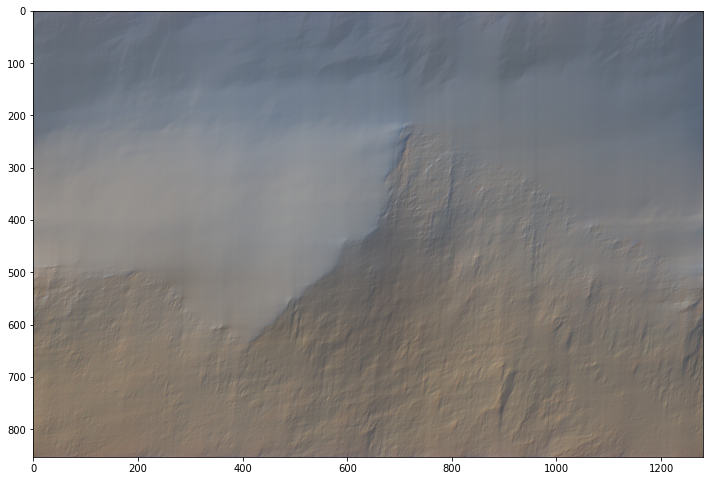

In [56]:
transformed_image = np.transpose(np.vstack([transformed_channels]), axes=[1 , 2, 0]).astype(int)
plt.figure(figsize=(12, 16))
plt.imshow(transformed_image);
plt.savefig("out2.jpeg")


# Задание 2. Фурье-преобразование звука.

Возьмите файл in10.wav и, используя sound.py,  добавьте в его фурье-образ низкочастотный шум. Сохраните результат в out1.wav.
После этого обрежьте нижние частоты в фурье-образе и сохраните в out2.wav.